# 3. Classical Inference

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import json

from pathlib import Path
from scipy.stats import uniform, norm, gamma

# setting font sizeto 16
plt.rcParams.update({'font.size': 16})

In [82]:
MAIN_DIR = Path.cwd().parent
DATA_DIR = MAIN_DIR / 'data'
EXP_DIR = MAIN_DIR / 'experiments'
NOTEBOOKS_DIR = MAIN_DIR / 'notebooks'
RESULTS_DIR = MAIN_DIR / 'results'
SRC_DIR = MAIN_DIR / 'src'

FIGURES_DIR = RESULTS_DIR / 'figures'

In [83]:
sys.path.append(str(SRC_DIR))

import classical_inference
import simulation
importlib.reload(classical_inference)
importlib.reload(simulation)

from classical_inference import ABC, create_array_simulation
from simulation import FullPredatorPreyModel

### 3.1 Importing Experimental Data

In [84]:
processed_data_dir = DATA_DIR / 'processed'
data_files = sorted(processed_data_dir.glob('*.csv'), key=lambda x: int(x.stem.split('_')[0].removeprefix('C')))

dfs = {f.stem.split('_')[0]: pd.read_csv(f) for f in data_files}
column_units_dict = {}  # Store units per dataset

# Only experiments C1 - C5 have the same conditions
experiment_names = ['C1', 'C2', 'C3', 'C4', 'C5']
experiment_data = []

for name in experiment_names:
    df = dfs[name]

    # Extract time column
    sim_time_values = df["time"].values  # Assuming the first column is time

    # Extract observable values (excluding time and medium column)
    algae_values = df["algae"]
    rotifers_values = df["rotifers"]
    egg_values = df["eggs"]
    egg_ratio_values = df["egg-ratio"]
    dead_animals_values = df["dead animals"]
    sim_observable_values = np.array([algae_values,
                                      rotifers_values,
                                      egg_values,
                                      egg_ratio_values,
                                      dead_animals_values])

    # Combine time and observables into a single array
    structured_data = np.vstack([sim_time_values, sim_observable_values])

    # Store in dictionary
    experiment_data.append(structured_data)

print('Data loaded successfully')
print('Data shape:', experiment_data[0].shape)

Data loaded successfully
Data shape: (6, 366)


### 3.2 Parameter Inference with ABC-MCMC

We want to use the ABC-MCMC algorithm highlighted in "Approximate Bayesian Computation scheme for parameter inference and model selection in dynamical systems".

The algorithm is designed in the following:
- **M1**: Initialize $\theta_i$, $i=0$.
- **M2**: Propose $\theta^\ast$ according to a proposal distribution $q(\theta | \theta_i)$.
- **M3**: Simulate a dataset $x^\ast$ from $f(x|\theta^\ast)$.
- **M4**: If $d(x_0, x^\ast) \leq \epsilon$, go to **M5**, otherwise set $\theta_{i+1} = \theta_i$ and to **M6**.
- **M5**: Set $\theta_{i+1} = \theta^\ast$ with probability
  $$ \alpha = min\left(1, \frac{\pi(\theta^\ast)q(\theta_i|\theta^\ast)}{\pi(\theta_i)q(\theta^\ast|\theta_i)}\right) $$
  and $\theta_{i+1} = \theta_i$ with probability $1-\alpha$.
- **M6**: Set $i=i+1$, go to **M2**.

After multiple tests, the distance function does not seem to reliably decrease past 1200 which is why $\epsilon$ will be set to 1200 during the runs. 

In [85]:
priors = {
    "delta": uniform(0.4, 0.3),  # Uniform prior between 0.4 and 0.7
    "N_in": norm(80, 10),        # Normal prior (mean=80, std=10)
    "r_P": gamma(3, scale=1),    # Gamma prior (shape=3, scale=1)
    "r_B": gamma(2, scale=1),    # Gamma prior (shape=2, scale=1)
    "K_P": uniform(3, 3),        # Uniform prior between 3 and 6
    "K_B": uniform(10, 10),      # Uniform prior between 10 and 20
    "kappa": uniform(1, 0.5),    # Uniform prior between 1 and 1.5
    "epsilon": uniform(0.1, 0.4),# Uniform prior between 0.1 and 0.5
    "m": uniform(0.1, 0.2),      # Uniform prior between 0.1 and 0.3
    "beta": uniform(3, 4),       # Uniform prior between 3 and 7
    "theta": uniform(0.3, 0.6),  # Uniform prior between 0.3 and 0.9
    "tau": uniform(1, 2),        # Uniform prior between 1 and 3
    "a": uniform(0, 1),          # Autocorrelation between 0 and 1
    "sigma": uniform(0.01, 0.1), # Noise level between 0.01 and 0.11
    'nu_p': uniform(20, 15),     # Uniform prior between 20 and 35
    'nu_b': uniform(0.4, 0.5),   # Uniform prior between 0.4 and 0.9
    'P0': gamma(1, scale=1),     # Gamma prior (shape=1, scale=1)
    'E0': gamma(0.1, scale=0.1), # Gamma prior (shape=0.1, scale=0.1)
    'J0': gamma(0.1, scale=0.1), # Gamma prior (shape=0.1, scale=0.1)
    'A0': gamma(1, scale=1)      # Gamma prior (shape=1, scale=1)
}

epsilon = 1200

proposal_std = {
    "delta": 0.03,
    "N_in": 0.3,
    "r_P": 0.03,
    "r_B": 0.03,
    "K_P": 0.03,
    "K_B": 0.03,
    "kappa": 0.03,
    "epsilon": 0.03,
    "m": 0.03,
    "beta": 0.03,
    "theta": 0.03,
    "tau": 0.03,
    "a": 0.03,
    "sigma": 0.03,
    'nu_p': 0.03,
    'nu_b': 0.03,
    'P0': 0.01,
    'E0': 0.01,
    'J0': 0.01,
    'A0': 0.01
}

save_dir = EXP_DIR / 'classical' / 'ABC-MCMC' / 'Run-2'

accepted_params, distances, sim_data = ABC(
    FullPredatorPreyModel, priors, experiment_data,
    epsilon, proposal_std, T=400, num_steps=4000, randomize=False, save_dir=save_dir).run(30000)

ABC-MCMC: 100%|██████████| 30000/30000 [6:55:59<00:00,  1.20it/s]       


### 3.3 Visualize the Distance Function over Time

In order to visualize the distance over the course of ABC-MCMC iterations, we exclude outliers where the simulation diverged too much.
Over many tests all distances above 10000 are excluded.

In [117]:
def plot_distances(distances, max_distance=10000, moving_avg_window=50, log_scale=False, save=False, title="distances"):
    """
    Plot the distances over iterations while preserving iteration alignment.

    Parameters
    ----------
    distances : list or ndarray
        List of distances between simulated and observed data.
    max_distance : float, optional
        Threshold to mask large distances (default: 10000).
    moving_avg_window : int, optional
        Window size for the moving average (default: 50).
    log_scale : bool, optional
        Whether to use a logarithmic y-axis (default: False).
    save : bool, optional
        Whether to save the plot as a PNG file (default: False).
    title : str, optional
        Title of the plot (default: "distances").
    """
    distances = np.array(distances)

    # Replace distances above max_distance with -1 for plotting
    plot_distances = np.where(distances > max_distance, -1, distances)

    # Compute moving average only on valid distances (ignoring -1 values)
    valid_distances = distances[distances <= max_distance]
    if moving_avg_window > 1 and len(valid_distances) >= moving_avg_window:
        smoothed = np.convolve(valid_distances, np.ones(moving_avg_window) / moving_avg_window, mode='valid')
        smoothed_indices = np.where(distances <= max_distance)[0][moving_avg_window - 1:]  # Map back to full index range

    # Plot setup
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Plot raw distances (masking -1 values differently)
    plt.plot(range(len(plot_distances)), plot_distances, color="royalblue", alpha=0.5, label="Raw Distances")
    
    # Highlight ignored distances (-1) in a different color
    ignored_indices = np.where(plot_distances == -1)[0]
    if len(ignored_indices) > 0:
        plt.scatter(ignored_indices, [-1] * len(ignored_indices), color="gray", marker="x", label="Ignored (> max)", alpha=0.6)

    # Plot moving average
    if moving_avg_window > 1 and len(valid_distances) >= moving_avg_window:
        plt.plot(smoothed_indices, smoothed, color="red", linewidth=2, label="Moving Avg")

    # Labels and styling
    plt.xlabel("Iteration", fontsize=16)
    plt.ylabel("Distance", fontsize=16)
    plt.ylim(-5, max_distance)  # Allow space for -1 markers
    plt.title("Distance Between Simulated and Observed Data", fontsize=18)
    plt.legend()

    if log_scale:
        plt.yscale("log")

    if save:
        plt.savefig(FIGURES_DIR / "3-classical-inference" / "ABC-MCMC" / f"{title}.png", bbox_inches="tight")

    plt.show()

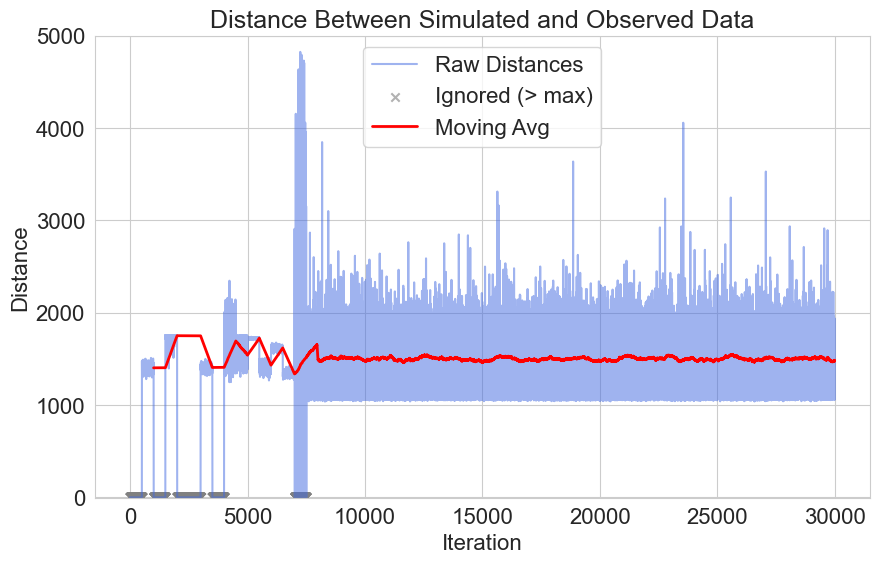

In [119]:
plot_distances(distances, max_distance=5000, moving_avg_window=500, log_scale=False, save=True, title="Run-2-distances")

### 3.4 Visualize the Simulations over Time

In [114]:
def plot_simulation_versus_experiment_data(sim_data, exp_data, unit_dict, time_range=None, save=False, title="simulation"):
    """
    Plot the simulated data for the predator-prey model.

    Parameters
    ----------
    sim_data : ndarray
        Array of simulated data for the predator-pre
    exp_data : ndarray
        Array of experimental data for the predator-prey model for one run.
    sim_data : ndarray
        Array of simulated data for the predator-pre
    unit_dict : dict
        Dictionary mapping column names to units.
    time_range : tuple, optional
        Range of time values to plot (default: None).
    save : bool, optional
        Whether to save the plot as a PNG file (default: False).
    title : str, optional
        Title of the plot (default: "simulation").
    """
    # Extract time values
    sim_time_values = sim_data[0, :]
    exp_time_values = exp_data[0, :]

    # Extract observable values
    sim_observable_values = sim_data[1:, :]
    exp_observable_values = exp_data[1:, :]

    observable_titles = ["Algae", "Rotifers", "Eggs", "Egg Ratio", "Dead Rotifers"]
    colors = ["green", "red", "black", "blue", "yellow"]
    max_values = [sim.max() if sim.max() >= exp.max() else exp.max() if i != 3 else 1
                  for i, (sim, exp) in enumerate(zip(sim_observable_values, exp_observable_values))]

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Plot each observable normalized by its maximum value
    for i, observable in enumerate(sim_observable_values):
            plt.plot(sim_time_values, observable, label=f"{observable_titles[i]}", color=colors[i])

    # Plot experimental data
    for i, observable in enumerate(exp_observable_values):
            plt.plot(exp_time_values, observable, color=colors[i], linestyle="--", marker="o")

    plt.xlabel(f"Time [{unit_dict.get('Time', '')}]", fontsize=16)
    plt.ylabel("Abundance", fontsize=16)
    plt.title("Simulated Data vs Experimental Data", fontsize=18)
    plt.legend()

    if time_range:
        plt.xlim(time_range)

    plt.ylim(-1, 70)

    if save:
        plt.savefig(FIGURES_DIR / "3-classical-inference" / "ABC-MCMC" / f"{title}.png", bbox_inches="tight")

    plt.show()

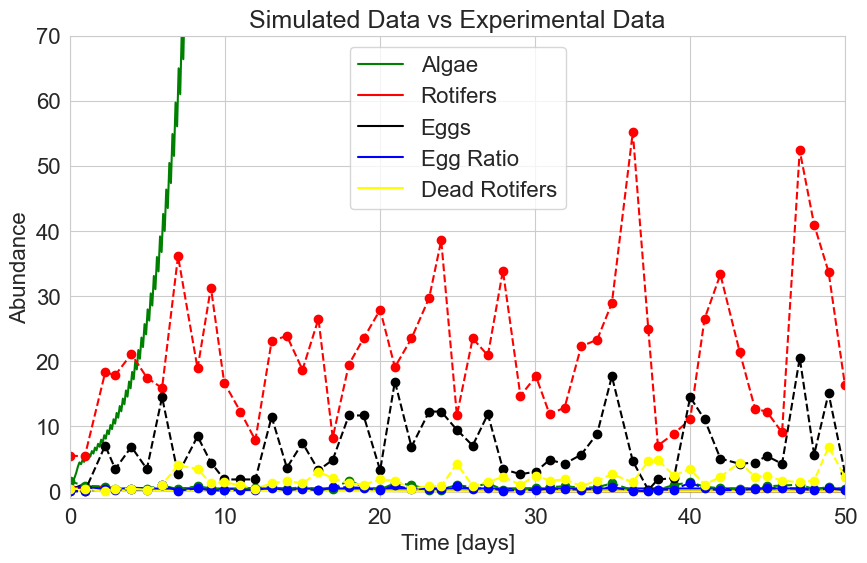

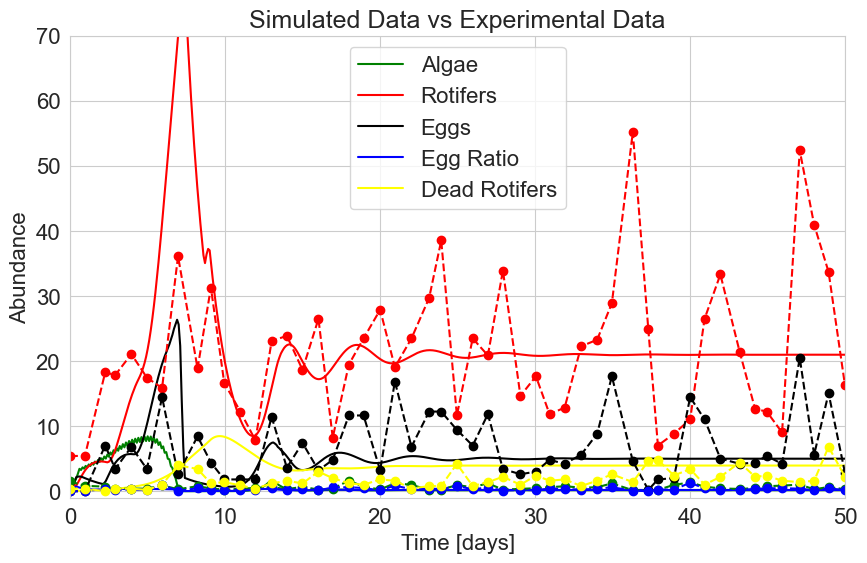

In [116]:
unit_dict = {'Time': 'days', 
            'Algae': '10^6 cells/ml',
            'Rotifers': 'animals/ml',
            'Egg Ratio': '%',
            'Eggs': '1/ml',
            'Dead Rotifers': '1/ml'}

# First plot the initial simulation
plot_simulation_versus_experiment_data(sim_data[0], experiment_data[0], unit_dict, time_range=(0, 50), save=True, title="Run-2-initial-simulation")

# Then plot the final simulation
plot_simulation_versus_experiment_data(sim_data[-1], experiment_data[0], unit_dict, time_range=(0, 50), save=True, title="Run-2-final-simulation")

### 3.5 Visualizing the Accepted Parameter Distributions

In [94]:
def plot_parameter_distribution(parameter_values, param_name, bins=30, save=False, exp_title=""):
    """
    Plot a histogram of the accepted parameter values.

    Parameters
    ----------
    parameter_values : ndarray
        Array of sampled values for the parameter.
    param_name : str
        Name of the parameter to display in the plot.
    bins : int, optional
        Number of bins for the histogram (default is 30).
    
    """
    plt.figure(figsize=(8, 5))
    sns.histplot(parameter_values, bins=bins, kde=True, color="royalblue", alpha=0.7)

    plt.xlabel(f"{param_name} Values", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.title(f"Posterior Distribution of {param_name}", fontsize=18)
    
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    if save:
        plt.savefig(FIGURES_DIR / "3-classical-inference" / "ABC-MCMC" / f"{exp_title}_{param_name}_distribution.png", bbox_inches="tight")
    plt.show()

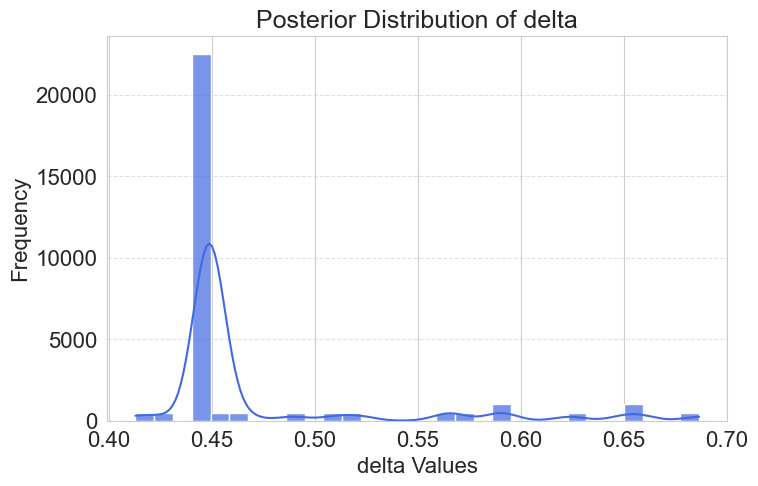

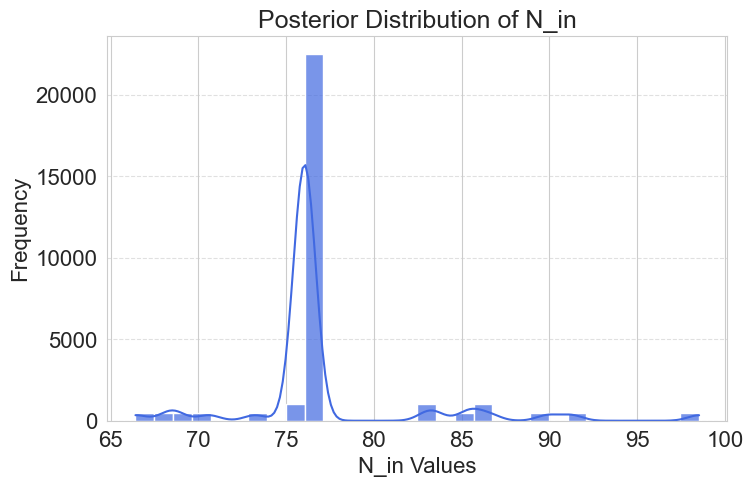

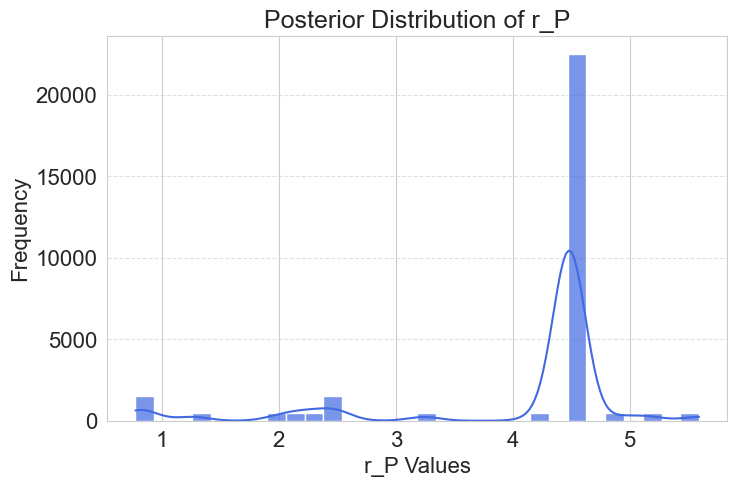

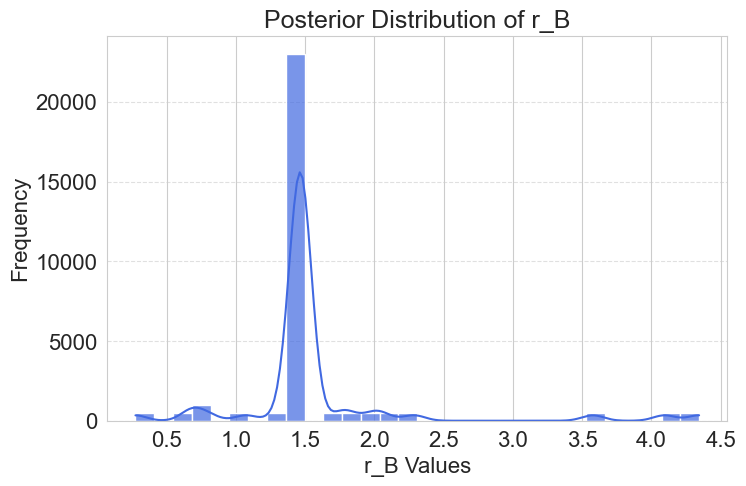

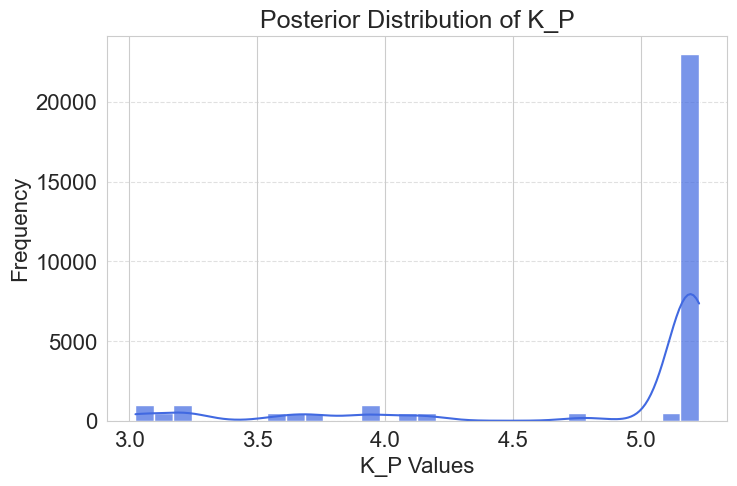

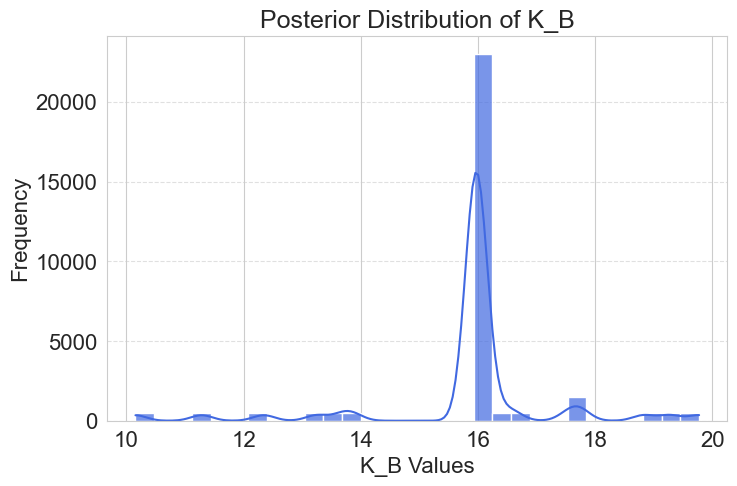

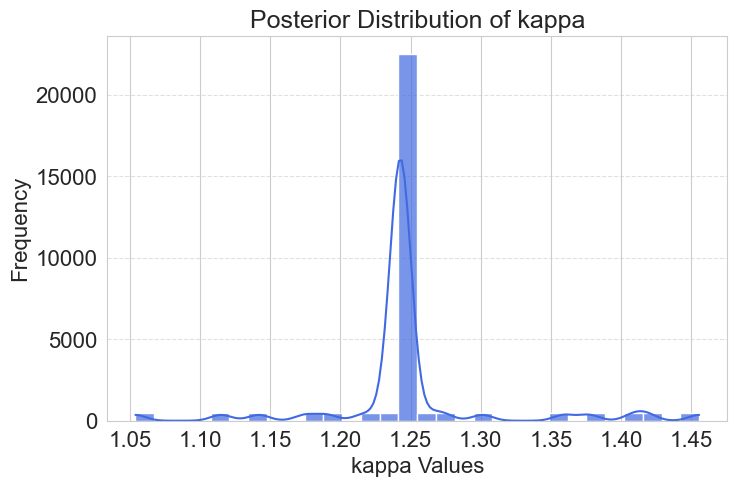

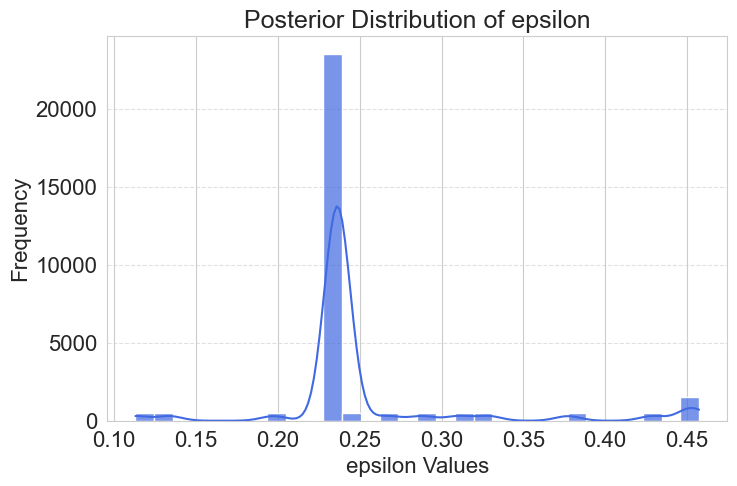

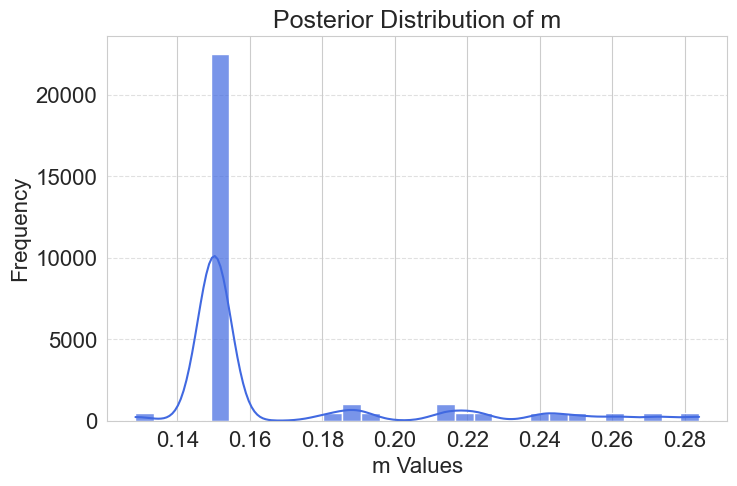

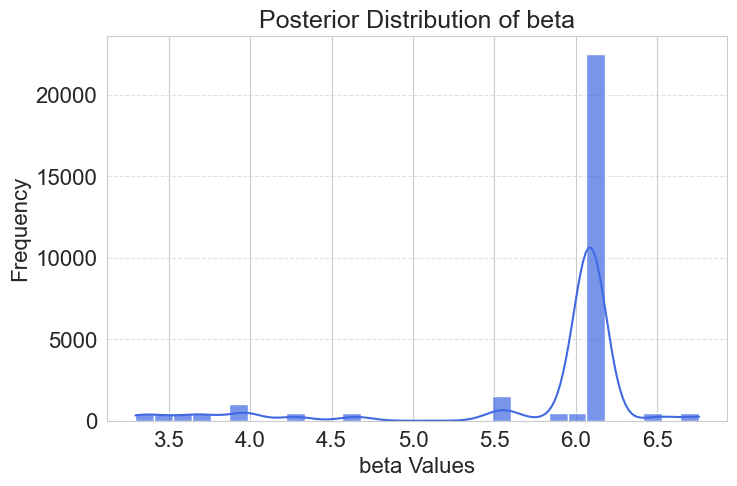

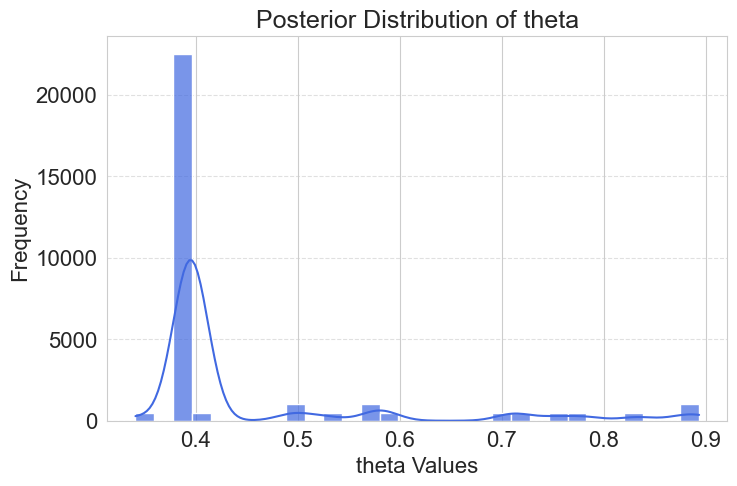

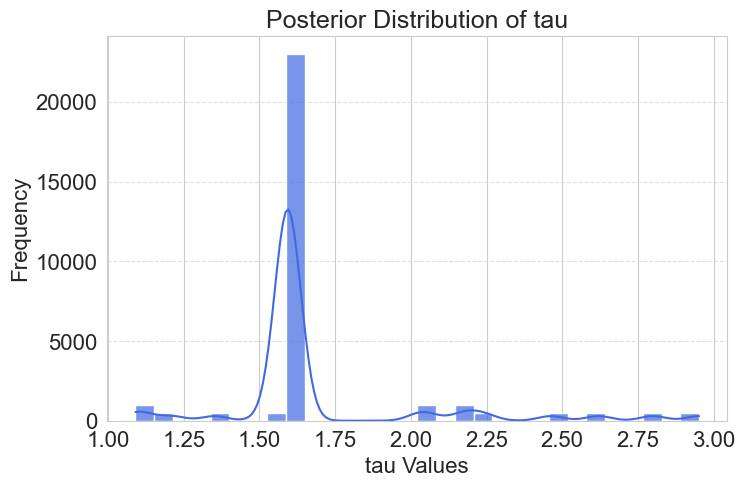

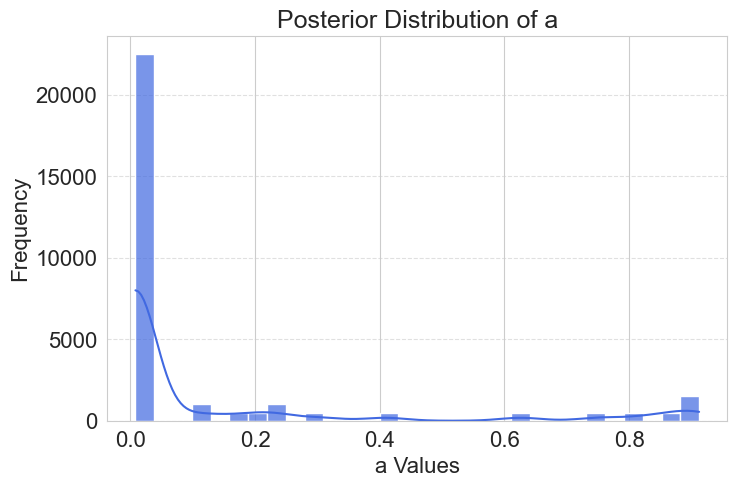

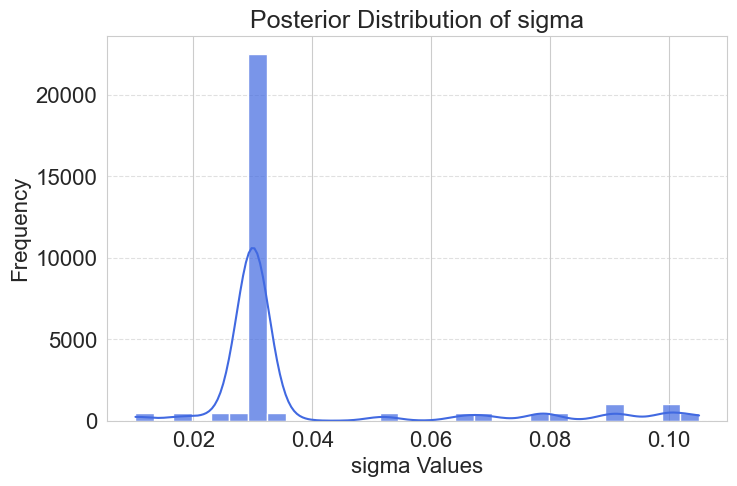

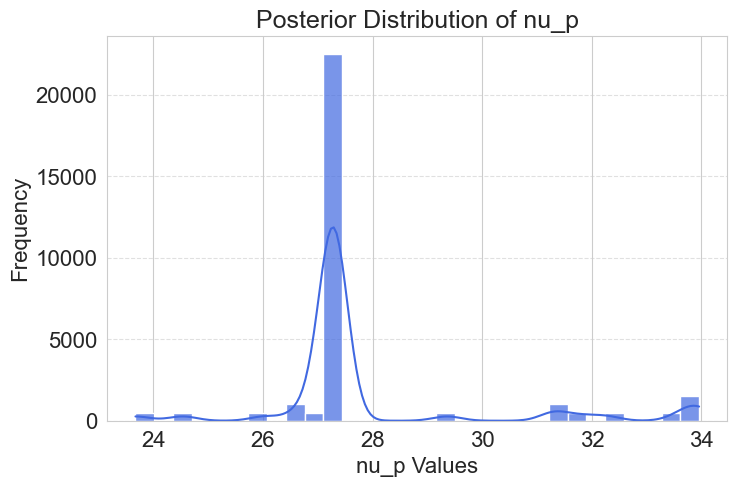

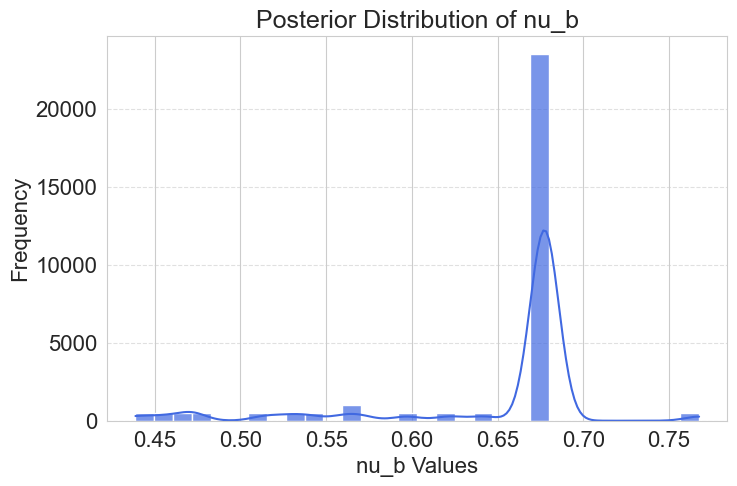

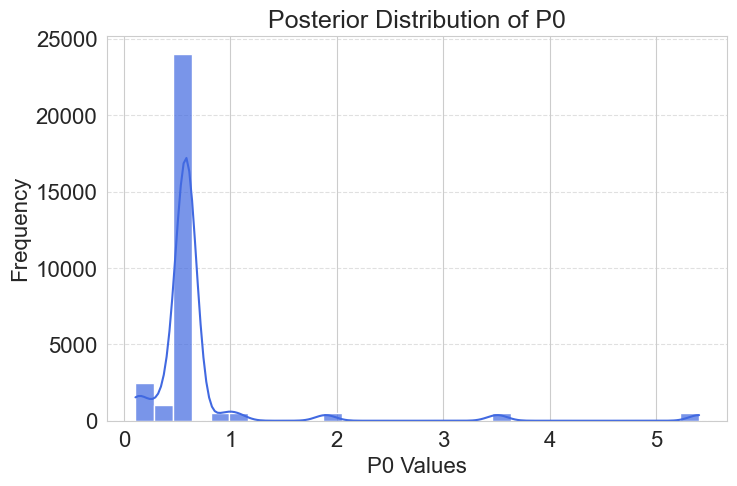

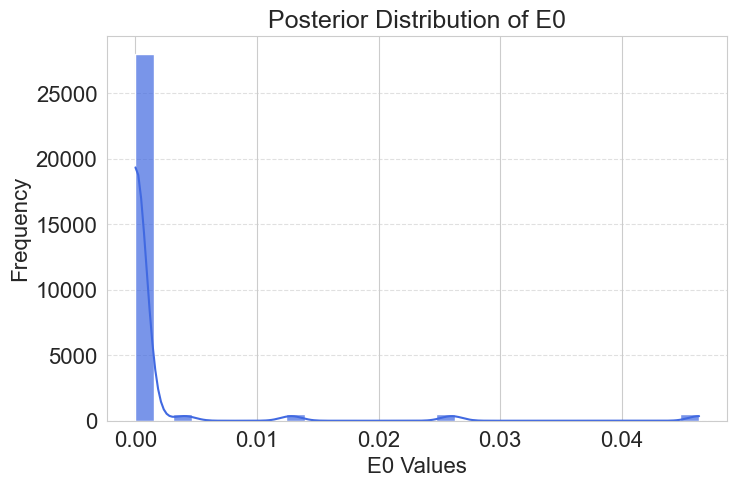

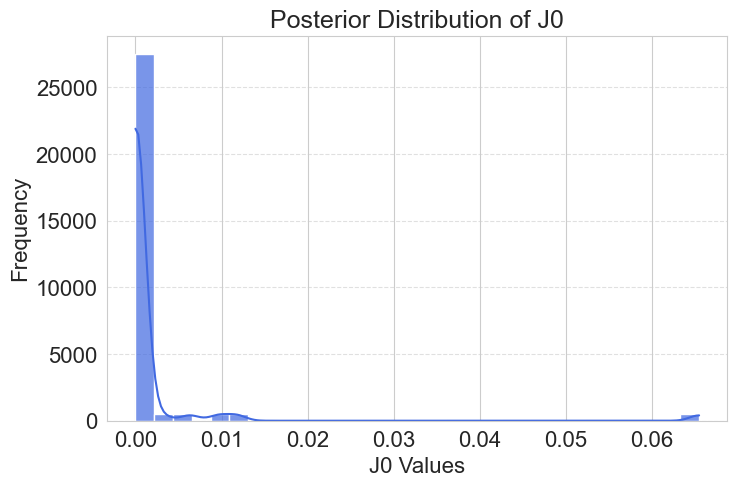

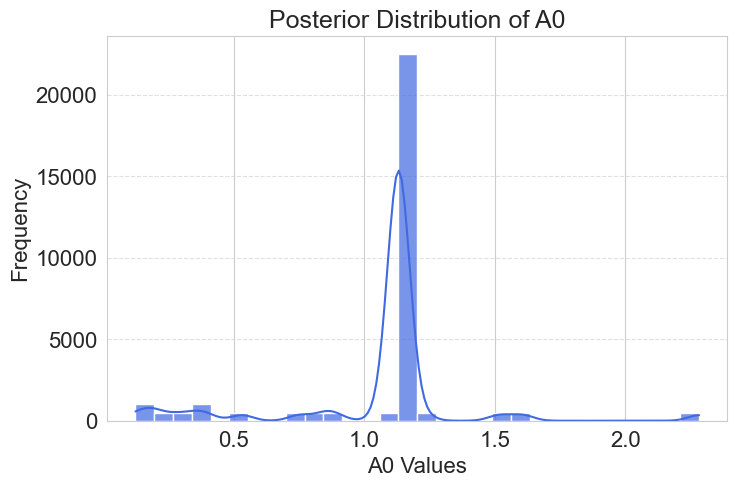

In [96]:
for param_name, param_values in accepted_params.items():
    plot_parameter_distribution(param_values, param_name, save=True, exp_title="Run2")

In [92]:
best_dist_index = np.argmin(distances)
best_distance = distances[best_dist_index]
print(f'Best distance: {best_distance:.4f}')
best_params = {key: val[best_dist_index] for key, val in accepted_params.items()}
print('Best parameters:')
for key, val in best_params.items():
    print(f'\t{key}: {val:.4f}')

Best distance: 1036.3840
Best parameters:
	delta: 0.4485
	N_in: 76.0481
	r_P: 4.4850
	r_B: 1.4653
	K_P: 5.1951
	K_B: 15.9702
	kappa: 1.2428
	epsilon: 0.2364
	m: 0.1502
	beta: 6.0880
	theta: 0.3947
	tau: 1.5938
	a: 0.0081
	sigma: 0.0300
	nu_p: 27.2810
	nu_b: 0.6774
	P0: 0.5864
	E0: 0.0000
	J0: 0.0001
	A0: 1.1313


### 3.6 ABC Distance for Paper Parameters

In [93]:
params = {
    'delta': 0.55, 'N_in': 80, 'r_P': 3.3, 'K_P': 4.3,
    'r_B': 2.25, 'K_B': 15, 'kappa': 1.25, 'epsilon': 0.25,
    'm': 0.15, 'beta': 5, 'theta': 0.6, 'tau': 1.8, 'a': 0.9,
    'sigma': 0.5, 'nu_p': 28, 'nu_b': 0.57,
    'P0': 1, 'E0': 0, 'J0': 0, 'A0': 0.1
}

X_sim = create_array_simulation(FullPredatorPreyModel, params, 400, 4000, randomize=False)
paper_dist = ABC(FullPredatorPreyModel, priors, experiment_data, epsilon, proposal_std, T=400, num_steps=4000, randomize=False).distance(experiment_data, X_sim)

print(f'Distance between paper and best parameters: {paper_dist:.4f}')


Distance between paper and best parameters: 3480.9837
